In [81]:
import pandas as pd
import kagglehub
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# Download latest dataset and load it in Pandas 

In [82]:
#Download latest version
path = kagglehub.dataset_download("nelgiriyewithana/world-stock-prices-daily-updating")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\s3phi\.cache\kagglehub\datasets\nelgiriyewithana\world-stock-prices-daily-updating\versions\355


In [83]:
#Load Data in pandas
data_path = path+"\World-Stock-Prices-Dataset.csv"
data = pd.read_csv(data_path)

<>:2: SyntaxWarning: invalid escape sequence '\W'
<>:2: SyntaxWarning: invalid escape sequence '\W'
C:\Users\s3phi\AppData\Local\Temp\ipykernel_35512\3204793938.py:2: SyntaxWarning: invalid escape sequence '\W'
  data_path = path+"\World-Stock-Prices-Dataset.csv"


# Exploring Data

In [84]:
#Check data content
data.head(10)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Brand_Name,Ticker,Industry_Tag,Country,Capital Gains
0,2025-05-21 00:00:00-04:00,6.550000,6.890000,6.450000,6.460000,18419100.0,0.0,0.0,peloton,PTON,fitness,usa,NaN
1,2025-05-21 00:00:00-04:00,111.120003,114.980003,111.120003,112.820000,1531300.0,0.0,0.0,crocs,CROX,footwear,usa,NaN
2,2025-05-21 00:00:00-04:00,71.690002,72.080002,71.580002,71.849998,12091100.0,0.0,0.0,the coca-cola company,KO,food & beverage,usa,NaN
3,2025-05-21 00:00:00-04:00,125.470001,125.470001,123.510002,123.589996,33200.0,0.0,0.0,adidas,ADDYY,apparel,germany,NaN
4,2025-05-21 00:00:00-04:00,293.040009,294.119995,285.109985,286.000000,3444900.0,0.0,0.0,american express,AXP,finance,usa,NaN
5,2025-05-21 00:00:00-04:00,25.799999,25.799999,25.799999,25.799999,100.0,0.0,0.0,puma,PMMAF,apparel,germany,NaN
6,2025-05-21 00:00:00-04:00,363.720001,365.989990,358.079987,358.299988,6124000.0,0.0,0.0,visa,V,finance,usa,NaN
7,2025-05-21 00:00:00-04:00,414.859985,422.950012,412.589996,414.029999,2494500.0,0.0,0.0,adobe,ADBE,technology,usa,NaN
8,2025-05-21 00:00:00-04:00,63.410000,63.730000,63.330002,63.459999,1471000.0,0.0,0.0,unilever,UL,consumer goods,netherlands,NaN
9,2025-05-21 00:00:00-04:00,62.990002,63.910000,62.970001,63.200001,15593500.0,0.0,0.0,cisco,CSCO,technology,usa,NaN


In [85]:
#Check data types
data.dtypes

Date              object
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
Dividends        float64
Stock Splits     float64
Brand_Name        object
Ticker            object
Industry_Tag      object
Country           object
Capital Gains    float64
dtype: object

In [86]:
#Create DataFrame
df = pd.DataFrame(data)

In [87]:
#Filter Brand_Name by apple and filter columns by Date, Close, Brand_Name
df_apple = df.loc[df["Brand_Name"] == "apple", ["Date", "Close", "Brand_Name"]]
display(df_apple)

,Date,Close,Brand_Name
36,2025-05-21 00:00:00-04:00,202.089996,apple
68,2025-05-20 00:00:00-04:00,206.860001,apple
157,2025-05-19 00:00:00-04:00,208.779999,apple
238,2025-05-16 00:00:00-04:00,211.259995,apple
256,2025-05-16 00:00:00-04:00,211.259995,apple
...,...,...,...
307812,2000-01-07 00:00:00-05:00,0.754065,apple
307859,2000-01-06 00:00:00-05:00,0.719961,apple
307894,2000-01-05 00:00:00-05:00,0.788168,apple
307928,2000-01-04 00:00:00-05:00,0.776801,apple


In [88]:
df_apple.dtypes

Date           object
Close         float64
Brand_Name     object
dtype: object

In [89]:
# try:
#     df_apple['Date'] = pd.to_datetime(df_apple['Date'], utc=True)  #Parsing into UTC
# except Exception as e:
#     print("Error converting 'Date' column:", e)

# df_apple.head(10)

In [90]:
df_apple_preproc = df_apple.rename(columns={"Date": "timestamp", "Close": "target", "Brand_Name": "item_id"})
df_apple_preproc.head(5)

,timestamp,target,item_id
36,2025-05-21 00:00:00-04:00,202.089996,apple
68,2025-05-20 00:00:00-04:00,206.860001,apple
157,2025-05-19 00:00:00-04:00,208.779999,apple
238,2025-05-16 00:00:00-04:00,211.259995,apple
256,2025-05-16 00:00:00-04:00,211.259995,apple


In [91]:
df_apple_preproc["item_id"] = df_apple_preproc['item_id'].astype("string")
df_apple_preproc["timestamp"] = df_apple_preproc['timestamp'].astype("string")
df_apple_preproc.dtypes

timestamp    string[python]
target              float64
item_id      string[python]
dtype: object

In [92]:
timecut = df_apple_preproc["timestamp"].str.slice(stop=10) #Cut hh:mm:ss and timezone
timecut

36        2025-05-21
68        2025-05-20
157       2025-05-19
238       2025-05-16
256       2025-05-16
             ...    
307812    2000-01-07
307859    2000-01-06
307894    2000-01-05
307928    2000-01-04
307967    2000-01-03
Name: timestamp, Length: 6433, dtype: string

In [93]:
df_apple_preproc["timestamp"] = timecut
df_apple_preproc

,timestamp,target,item_id
36,2025-05-21,202.089996,apple
68,2025-05-20,206.860001,apple
157,2025-05-19,208.779999,apple
238,2025-05-16,211.259995,apple
256,2025-05-16,211.259995,apple
...,...,...,...
307812,2000-01-07,0.754065,apple
307859,2000-01-06,0.719961,apple
307894,2000-01-05,0.788168,apple
307928,2000-01-04,0.776801,apple


In [94]:
df_apple_preproc["timestamp"] = pd.to_datetime(timecut) #convert string into datetime64
df_apple_preproc.dtypes

timestamp    datetime64[ns]
target              float64
item_id      string[python]
dtype: object

In [95]:
df_apple_preproc.head(10)

,timestamp,target,item_id
36,2025-05-21,202.089996,apple
68,2025-05-20,206.860001,apple
157,2025-05-19,208.779999,apple
238,2025-05-16,211.259995,apple
256,2025-05-16,211.259995,apple
345,2025-05-15,211.449997,apple
366,2025-05-14,212.330002,apple
468,2025-05-13,212.929993,apple
490,2025-05-12,210.789993,apple
565,2025-05-05,198.889999,apple


In [96]:
df_apple_reordered =  df_apple_preproc[['item_id', 'timestamp', 'target']] #Reordering columns

df_apple_reordered

,item_id,timestamp,target
36,apple,2025-05-21,202.089996
68,apple,2025-05-20,206.860001
157,apple,2025-05-19,208.779999
238,apple,2025-05-16,211.259995
256,apple,2025-05-16,211.259995
...,...,...,...
307812,apple,2000-01-07,0.754065
307859,apple,2000-01-06,0.719961
307894,apple,2000-01-05,0.788168
307928,apple,2000-01-04,0.776801


In [97]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

data = TimeSeriesDataFrame.from_data_frame(
    df_apple_reordered,
    id_column="item_id",
    timestamp_column="timestamp"
)
data.head()

target
item_id timestamp             
apple   2025-05-21  202.089996
        2025-05-20  206.860001
        2025-05-19  208.779999
        2025-05-16  211.259995
        2025-05-16  211.259995

In [98]:
prediction_length = 50
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length, freq="d").fit(
    train_data, presets="bolt_small",
)

Sorting the dataframe index before generating the train/test split.
Frequency 'd' stored as 'D'
Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250522_192452'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       1.16 GB / 15.70 GB (7.4%)
Disk Space Avail:   63.11 GB / 475.50 GB (13.3%)
Setting presets to: bolt_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'D',
 'hyperparameters': {'Chronos': {'model_path': 'bolt_small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 50,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'v

data with frequency 'IRREG' has been resampled to frequency 'D'.
Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_small]
data with frequency 'IRREG' has been resampled to frequency 'D'.


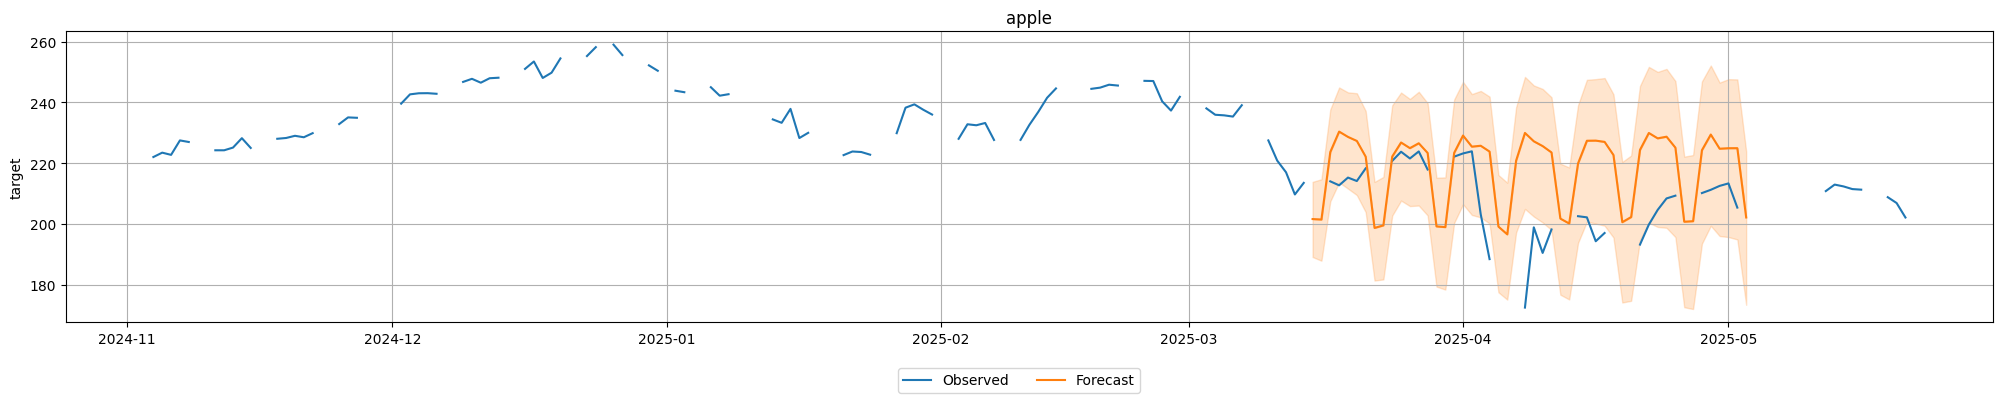

In [99]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:20],
    max_history_length=200,
);

# Better Preproccessing

In [100]:
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from autogluon.timeseries.splitter import ExpandingWindowSplitter


In [101]:
df_irregular = TimeSeriesDataFrame(
    pd.DataFrame(df_apple_reordered)
)
df_irregular.head(10)

target
item_id timestamp             
apple   2025-05-21  202.089996
        2025-05-20  206.860001
        2025-05-19  208.779999
        2025-05-16  211.259995
        2025-05-16  211.259995
        2025-05-15  211.449997
        2025-05-14  212.330002
        2025-05-13  212.929993
        2025-05-12  210.789993
        2025-05-05  198.889999

In [102]:
df_regular = df_irregular.convert_frequency(freq="D")
df_regular.tail(10)

target
item_id timestamp             
apple   2025-05-12  210.789993
        2025-05-13  212.929993
        2025-05-14  212.330002
        2025-05-15  211.449997
        2025-05-16  211.259995
        2025-05-17         NaN
        2025-05-18         NaN
        2025-05-19  208.779999
        2025-05-20  206.860001
        2025-05-21  202.089996

In [103]:
df_filled = df_regular.fill_missing_values()
df_filled.tail(10)

target
item_id timestamp             
apple   2025-05-12  210.789993
        2025-05-13  212.929993
        2025-05-14  212.330002
        2025-05-15  211.449997
        2025-05-16  211.259995
        2025-05-17  211.259995
        2025-05-18  211.259995
        2025-05-19  208.779999
        2025-05-20  206.860001
        2025-05-21  202.089996

In [104]:
data = TimeSeriesDataFrame.from_data_frame(
    df = df_filled,
    id_column="item_id",
    timestamp_column="timestamp"
)
data

target
item_id timestamp             
apple   2000-01-03    0.848323
        2000-01-04    0.776801
        2000-01-05    0.788168
        2000-01-06    0.719961
        2000-01-07    0.754065
...                        ...
        2025-05-17  211.259995
        2025-05-18  211.259995
        2025-05-19  208.779999
        2025-05-20  206.860001
        2025-05-21  202.089996

[9271 rows x 1 columns]

In [113]:
prediction_length = 30
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="bolt_base",
)

Beginning AutoGluon training...
AutoGluon will save models to 'c:\workspace\CrimeMap\AutogluonModels\ag-20250522_192715'
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.1
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       1.62 GB / 15.70 GB (10.3%)
Disk Space Avail:   63.11 GB / 475.50 GB (13.3%)
Setting presets to: bolt_base

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'bolt_base'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'D'
Provided train_data has 9241 rows, 1 time series. Median tim

Model not specified in predict, will default to the model with the best validation score: Chronos[bolt_base]


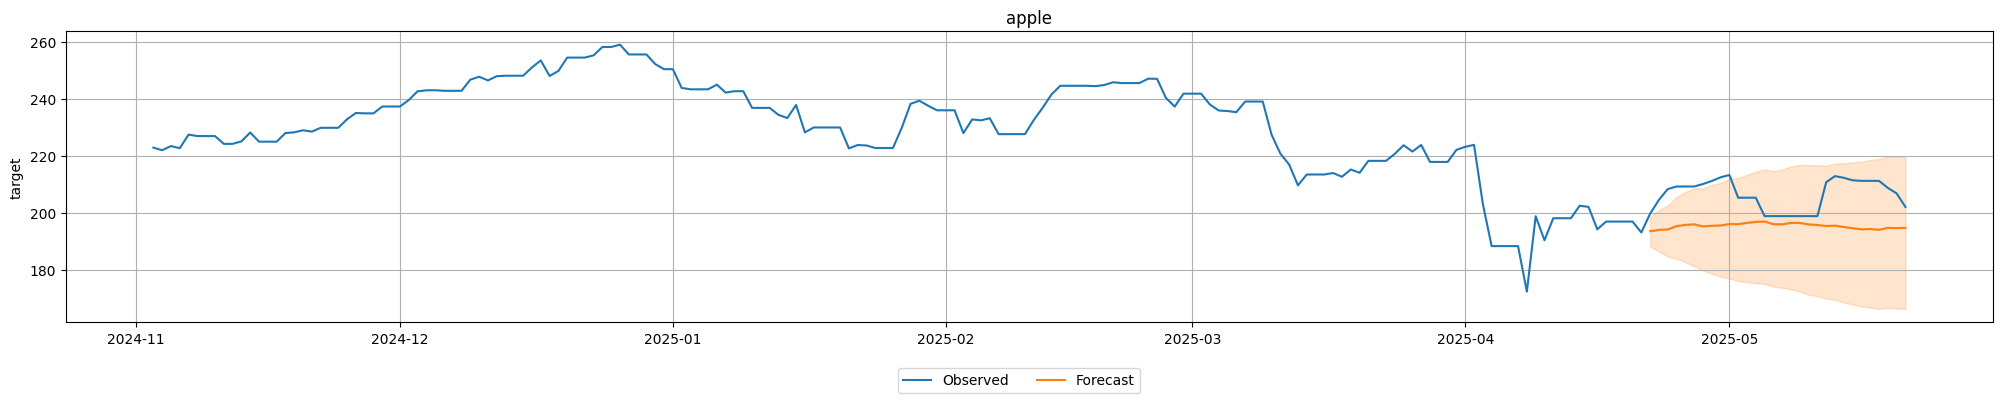

In [114]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=data.item_ids[:2],
    max_history_length=200,
);